# MNIST Handwritten Digit Classification - Training

PyTorch implementation for MNIST digit classification model training

## 1. Import Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 3060


## 2. Configuration & Hyperparameters

In [3]:
# Hyperparameters
CONFIG = {
    'batch_size': 128,
    'epochs': 30,
    'learning_rate': 0.001,
    'val_split': 0.15,
    'num_classes': 10,
    'img_size': 28,
    'channels': 1,
    'model_save_path': 'models/',
    'best_model_name': 'best_mnist_model.pth',
    'final_model_name': 'final_mnist_model.pth'
}

# Create model directory
os.makedirs(CONFIG['model_save_path'], exist_ok=True)

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  batch_size: 128
  epochs: 30
  learning_rate: 0.001
  val_split: 0.15
  num_classes: 10
  img_size: 28
  channels: 1
  model_save_path: models/
  best_model_name: best_mnist_model.pth
  final_model_name: final_mnist_model.pth


## 3. Load and Prepare Data

In [4]:
# Load data
train_df = pd.read_csv('digit-recognizer/train.csv')

print(f"Dataset shape: {train_df.shape}")
print(f"\nClass distribution:")
print(train_df['label'].value_counts().sort_index())

Dataset shape: (42000, 785)

Class distribution:
0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64


## 4. Custom Dataset Class

In [5]:
class MNISTDataset(Dataset):
    def __init__(self, data, labels=None, transform=None):
        """
        Args:
            data: pixel data (N, 784) numpy array
            labels: labels (N,) numpy array or None for test set
            transform: optional transforms to apply
        """
        self.data = data
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Get image and reshape to (28, 28)
        image = self.data[idx].reshape(28, 28).astype(np.float32)
        
        # Normalize to [0, 1]
        image = image / 255.0
        
        # Add channel dimension: (1, 28, 28)
        image = np.expand_dims(image, axis=0)
        
        # Convert to tensor
        image = torch.from_numpy(image)
        
        if self.labels is not None:
            label = self.labels[idx]
            return image, label
        else:
            return image

## 5. Prepare Train/Validation Split

In [6]:
# Split features and labels
X = train_df.drop('label', axis=1).values
y = train_df['label'].values

# Train/Validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=CONFIG['val_split'], 
    random_state=SEED,
    stratify=y
)

print(f"Training samples: {len(X_train):,}")
print(f"Validation samples: {len(X_val):,}")

# Create datasets
train_dataset = MNISTDataset(X_train, y_train)
val_dataset = MNISTDataset(X_val, y_val)

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=False,
    num_workers=0
)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Training samples: 35,700
Validation samples: 6,300

Train batches: 279
Validation batches: 50


## 6. Visualize Sample Data

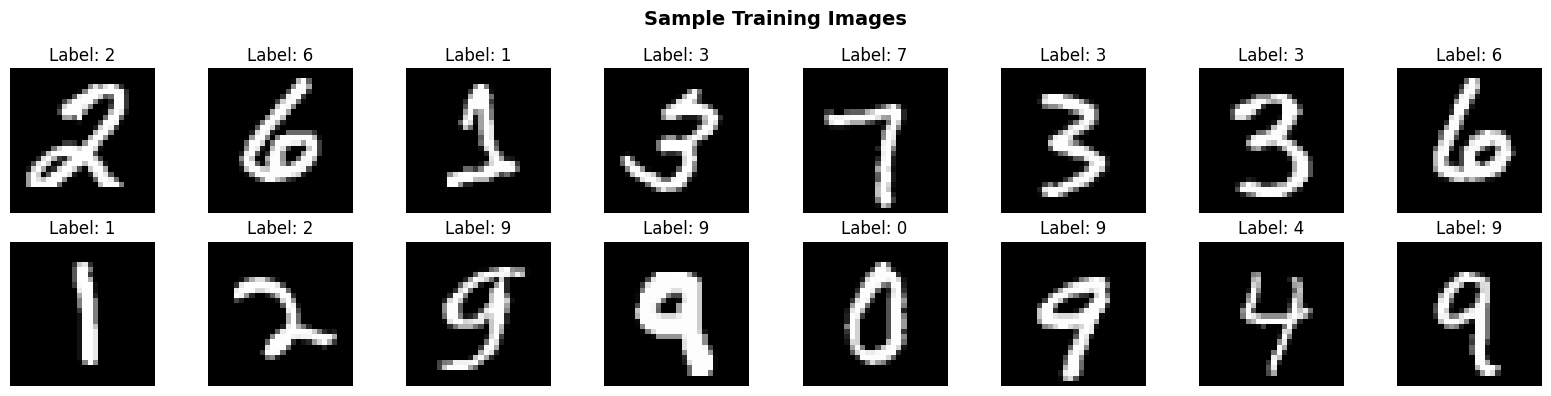

In [7]:
# Visualize sample batch
sample_batch, sample_labels = next(iter(train_loader))

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
axes = axes.flatten()

for i in range(16):
    img = sample_batch[i].squeeze().numpy()
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'Label: {sample_labels[i].item()}')
    axes[i].axis('off')

plt.suptitle('Sample Training Images', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Define CNN Model

In [8]:
class MNISTNet(nn.Module):
    def __init__(self, num_classes=10):
        super(MNISTNet, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 28x28x32
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)  # 28x28x32
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)  # 14x14x32
        self.dropout1 = nn.Dropout2d(0.25)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 14x14x64
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)  # 14x14x64
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)  # 7x7x64
        self.dropout2 = nn.Dropout2d(0.25)
        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 7x7x128
        self.bn5 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)  # 3x3x128
        self.dropout3 = nn.Dropout2d(0.25)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Block 3
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected
        x = F.relu(self.bn6(self.fc1(x)))
        x = self.dropout4(x)
        x = self.fc2(x)
        
        return x

In [9]:
# Initialize model
model = MNISTNet(num_classes=CONFIG['num_classes']).to(device)

# Print model summary
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

MNISTNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1),

## 8. Training Setup

In [10]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=3, 
    verbose=True,
    min_lr=1e-6
)

print("Training setup complete!")
print(f"Criterion: {criterion}")
print(f"Optimizer: {optimizer.__class__.__name__}")
print(f"Scheduler: {scheduler.__class__.__name__}")

Training setup complete!
Criterion: CrossEntropyLoss()
Optimizer: Adam
Scheduler: ReduceLROnPlateau


## 9. Training & Validation Functions

In [11]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc='Training', leave=False)
    
    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc


def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc='Validation', leave=False)
    
    with torch.no_grad():
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * correct / total:.2f}%'
            })
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

## 10. Train the Model

In [12]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
best_epoch = 0

print("="*60)
print("Starting Training")
print("="*60)

for epoch in range(CONFIG['epochs']):
    print(f"\nEpoch [{epoch+1}/{CONFIG['epochs']}]")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print epoch summary
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss
        }, os.path.join(CONFIG['model_save_path'], CONFIG['best_model_name']))
        print(f"*** New best model saved! (Acc: {val_acc:.2f}%) ***")

print("\n" + "="*60)
print("Training Complete!")
print("="*60)
print(f"Best validation accuracy: {best_val_acc:.2f}% at epoch {best_epoch}")

Starting Training

Epoch [1/30]


Train Loss: 0.2849 | Train Acc: 92.10%
Val Loss:   0.0470 | Val Acc:   98.60%
*** New best model saved! (Acc: 98.60%) ***

Epoch [2/30]


Train Loss: 0.0674 | Train Acc: 98.05%
Val Loss:   0.0350 | Val Acc:   98.89%
*** New best model saved! (Acc: 98.89%) ***

Epoch [3/30]


Train Loss: 0.0535 | Train Acc: 98.31%
Val Loss:   0.0357 | Val Acc:   98.89%

Epoch [4/30]


Train Loss: 0.0431 | Train Acc: 98.70%
Val Loss:   0.0282 | Val Acc:   99.13%
*** New best model saved! (Acc: 99.13%) ***

Epoch [5/30]


Train Loss: 0.0371 | Train Acc: 98.93%
Val Loss:   0.0314 | Val Acc:   99.08%

Epoch [6/30]


Train Loss: 0.0324 | Train Acc: 99.00%
Val Loss:   0.0280 | Val Acc:   99.06%

Epoch [7/30]


Train Loss: 0.0302 | Train Acc: 99.08%
Val Loss:   0.0237 | Val Acc:   99.32%
*** New best model saved! (Acc: 99.32%) ***

Epoch [8/30]


Train Loss: 0.0264 | Train Acc: 99.18%
Val Loss:   0.0308 | Val Acc:   99.17%

Epoch [9/30]


Train Loss: 0.0279 | Train Acc: 99.10%
Val Loss:   0.0308 | Val Acc:   99.11%

Epoch [10/30]


Train Loss: 0.0215 | Train Acc: 99.34%
Val Loss:   0.0261 | Val Acc:   99.30%

Epoch [11/30]


Train Loss: 0.0207 | Train Acc: 99.38%
Val Loss:   0.0286 | Val Acc:   99.29%

Epoch [12/30]


Train Loss: 0.0158 | Train Acc: 99.47%
Val Loss:   0.0232 | Val Acc:   99.37%
*** New best model saved! (Acc: 99.37%) ***

Epoch [13/30]


Train Loss: 0.0122 | Train Acc: 99.63%
Val Loss:   0.0259 | Val Acc:   99.38%
*** New best model saved! (Acc: 99.38%) ***

Epoch [14/30]


Train Loss: 0.0121 | Train Acc: 99.61%
Val Loss:   0.0226 | Val Acc:   99.43%
*** New best model saved! (Acc: 99.43%) ***

Epoch [15/30]


Train Loss: 0.0113 | Train Acc: 99.64%
Val Loss:   0.0243 | Val Acc:   99.40%

Epoch [16/30]


Train Loss: 0.0106 | Train Acc: 99.65%
Val Loss:   0.0251 | Val Acc:   99.38%

Epoch [17/30]


Train Loss: 0.0111 | Train Acc: 99.66%
Val Loss:   0.0243 | Val Acc:   99.35%

Epoch [18/30]


Train Loss: 0.0108 | Train Acc: 99.64%
Val Loss:   0.0254 | Val Acc:   99.37%

Epoch [19/30]


Train Loss: 0.0084 | Train Acc: 99.75%
Val Loss:   0.0224 | Val Acc:   99.46%
*** New best model saved! (Acc: 99.46%) ***

Epoch [20/30]


Train Loss: 0.0057 | Train Acc: 99.85%
Val Loss:   0.0232 | Val Acc:   99.48%
*** New best model saved! (Acc: 99.48%) ***

Epoch [21/30]


Train Loss: 0.0068 | Train Acc: 99.81%
Val Loss:   0.0259 | Val Acc:   99.43%

Epoch [22/30]


Train Loss: 0.0071 | Train Acc: 99.82%
Val Loss:   0.0254 | Val Acc:   99.44%

Epoch [23/30]


Train Loss: 0.0056 | Train Acc: 99.82%
Val Loss:   0.0259 | Val Acc:   99.38%

Epoch [24/30]


Train Loss: 0.0054 | Train Acc: 99.85%
Val Loss:   0.0247 | Val Acc:   99.43%

Epoch [25/30]


Train Loss: 0.0047 | Train Acc: 99.86%
Val Loss:   0.0242 | Val Acc:   99.40%

Epoch [26/30]


Train Loss: 0.0044 | Train Acc: 99.87%
Val Loss:   0.0252 | Val Acc:   99.44%

Epoch [27/30]


Train Loss: 0.0040 | Train Acc: 99.88%
Val Loss:   0.0258 | Val Acc:   99.40%

Epoch [28/30]


Train Loss: 0.0038 | Train Acc: 99.89%
Val Loss:   0.0247 | Val Acc:   99.48%

Epoch [29/30]


Train Loss: 0.0037 | Train Acc: 99.89%
Val Loss:   0.0241 | Val Acc:   99.49%
*** New best model saved! (Acc: 99.49%) ***

Epoch [30/30]


Train Loss: 0.0034 | Train Acc: 99.91%
Val Loss:   0.0253 | Val Acc:   99.44%

Training Complete!
Best validation accuracy: 99.49% at epoch 29


## 11. Save Final Model

In [13]:
# Save final model
torch.save({
    'epoch': CONFIG['epochs'],
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'config': CONFIG
}, os.path.join(CONFIG['model_save_path'], CONFIG['final_model_name']))

print(f"Final model saved to: {os.path.join(CONFIG['model_save_path'], CONFIG['final_model_name'])}")

Final model saved to: models/final_mnist_model.pth


## 12. Visualize Training History

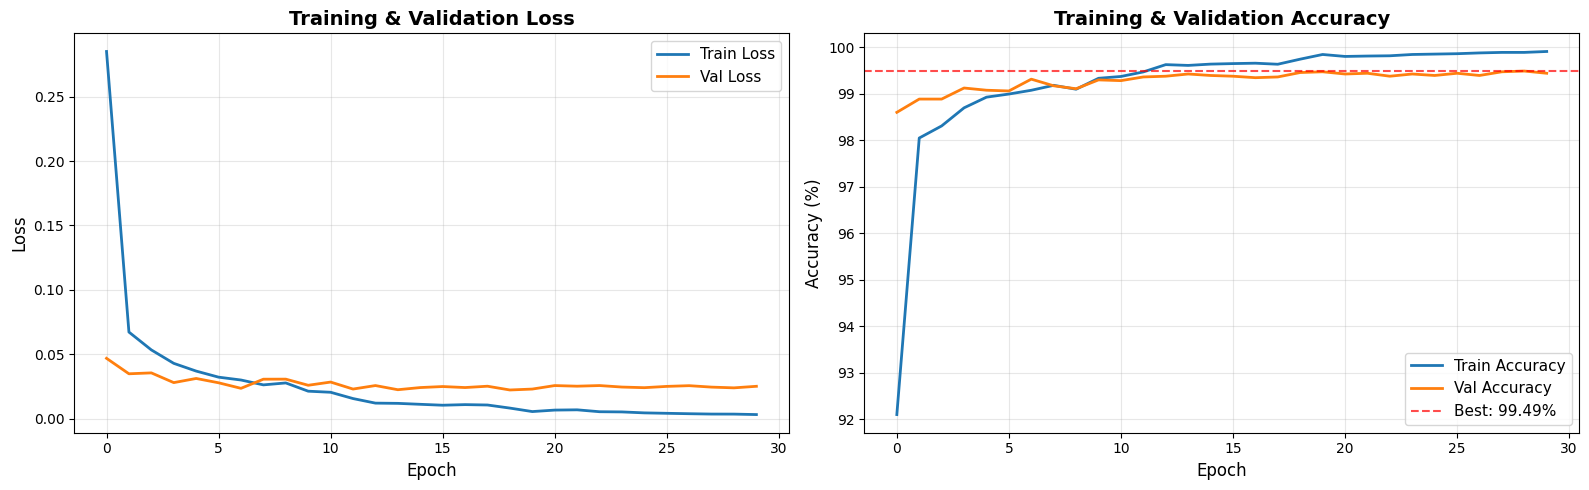

Training history plot saved!


In [14]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Accuracy', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Accuracy', linewidth=2)
axes[1].axhline(y=best_val_acc, color='r', linestyle='--', alpha=0.7, label=f'Best: {best_val_acc:.2f}%')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['model_save_path'], 'training_history.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"Training history plot saved!")

## 13. Evaluate on Validation Set

In [15]:
# Load best model
checkpoint = torch.load(os.path.join(CONFIG['model_save_path'], CONFIG['best_model_name']))
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")

# Get predictions
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc='Evaluating'):
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

Loaded best model from epoch 29


Evaluating: 100%|██████████| 50/50 [00:00<00:00, 157.08it/s]


## 14. Confusion Matrix

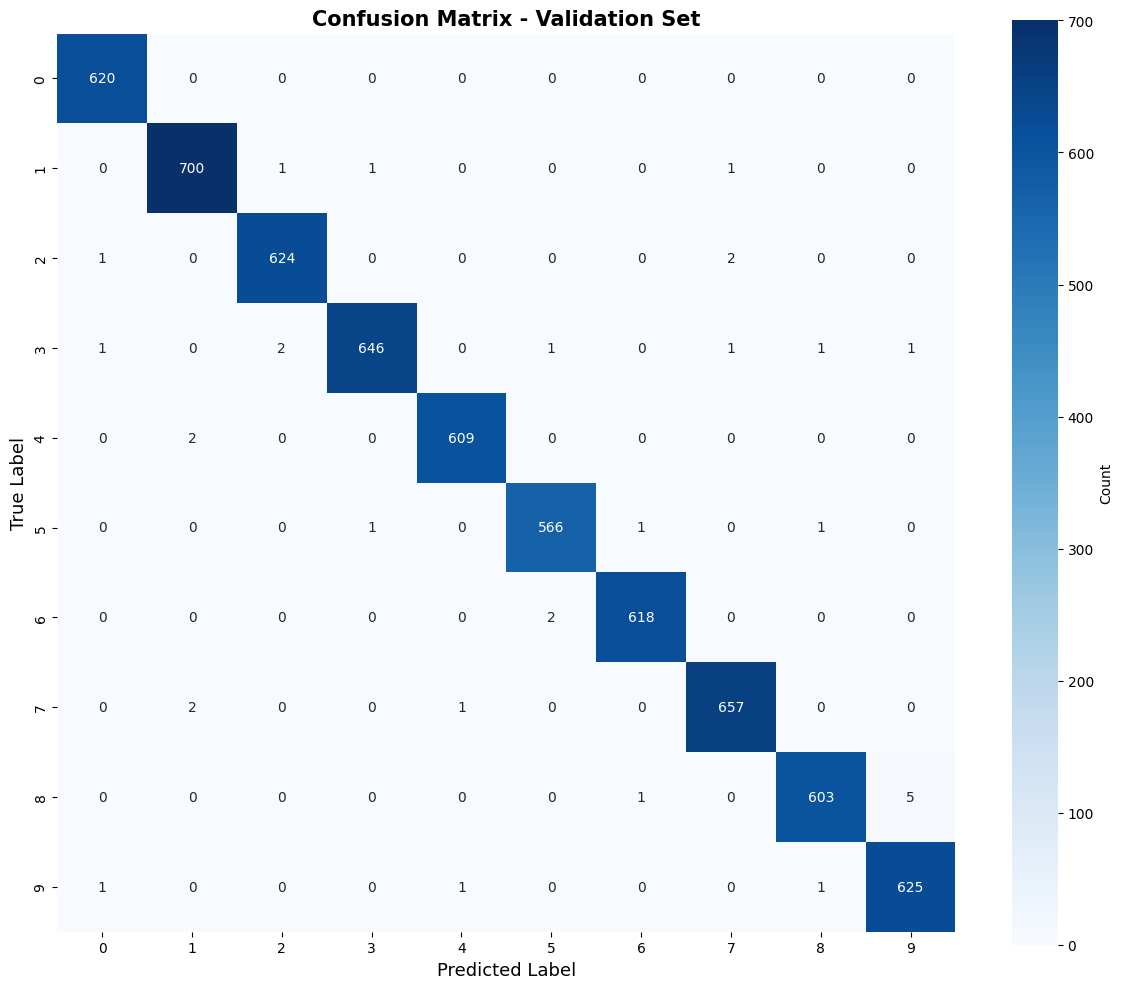

Confusion matrix saved!


In [16]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=13)
plt.ylabel('True Label', fontsize=13)
plt.title('Confusion Matrix - Validation Set', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['model_save_path'], 'confusion_matrix.png'), dpi=150, bbox_inches='tight')
plt.show()

print("Confusion matrix saved!")

## 15. Classification Report

In [17]:
# Print classification report
print("Classification Report:")
print("="*60)
print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(10)]))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       620
           1       0.99      1.00      1.00       703
           2       1.00      1.00      1.00       627
           3       1.00      0.99      0.99       653
           4       1.00      1.00      1.00       611
           5       0.99      0.99      0.99       569
           6       1.00      1.00      1.00       620
           7       0.99      1.00      0.99       660
           8       1.00      0.99      0.99       609
           9       0.99      1.00      0.99       628

    accuracy                           0.99      6300
   macro avg       0.99      0.99      0.99      6300
weighted avg       0.99      0.99      0.99      6300



## 16. Visualize Predictions

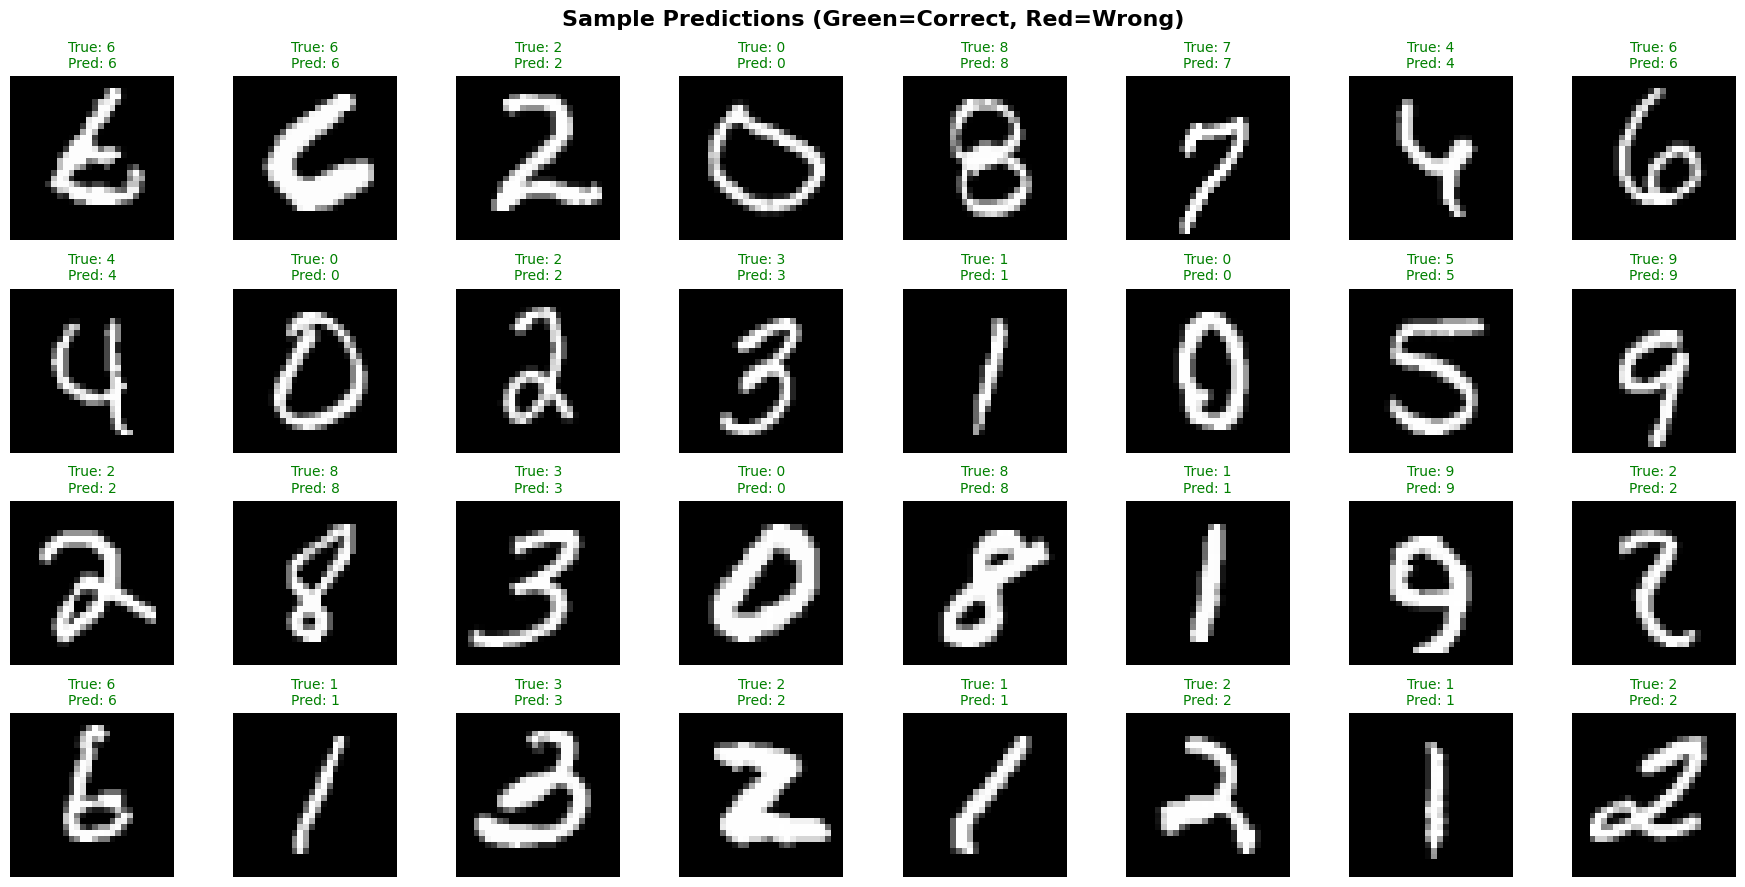

In [18]:
# Visualize some predictions
model.eval()

# Get a batch
images, labels = next(iter(val_loader))
images = images.to(device)

with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Plot predictions
fig, axes = plt.subplots(4, 8, figsize=(18, 9))
axes = axes.flatten()

for i in range(32):
    img = images[i].cpu().squeeze().numpy()
    true_label = labels[i].item()
    pred_label = predicted[i].item()
    
    axes[i].imshow(img, cmap='gray')
    
    if true_label == pred_label:
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}', color='green', fontsize=10)
    else:
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}', color='red', fontsize=10)
    
    axes[i].axis('off')

plt.suptitle('Sample Predictions (Green=Correct, Red=Wrong)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['model_save_path'], 'sample_predictions.png'), dpi=150, bbox_inches='tight')
plt.show()

## 17. Find Misclassified Examples

Total misclassified samples: 32 out of 6300
Misclassification rate: 0.51%


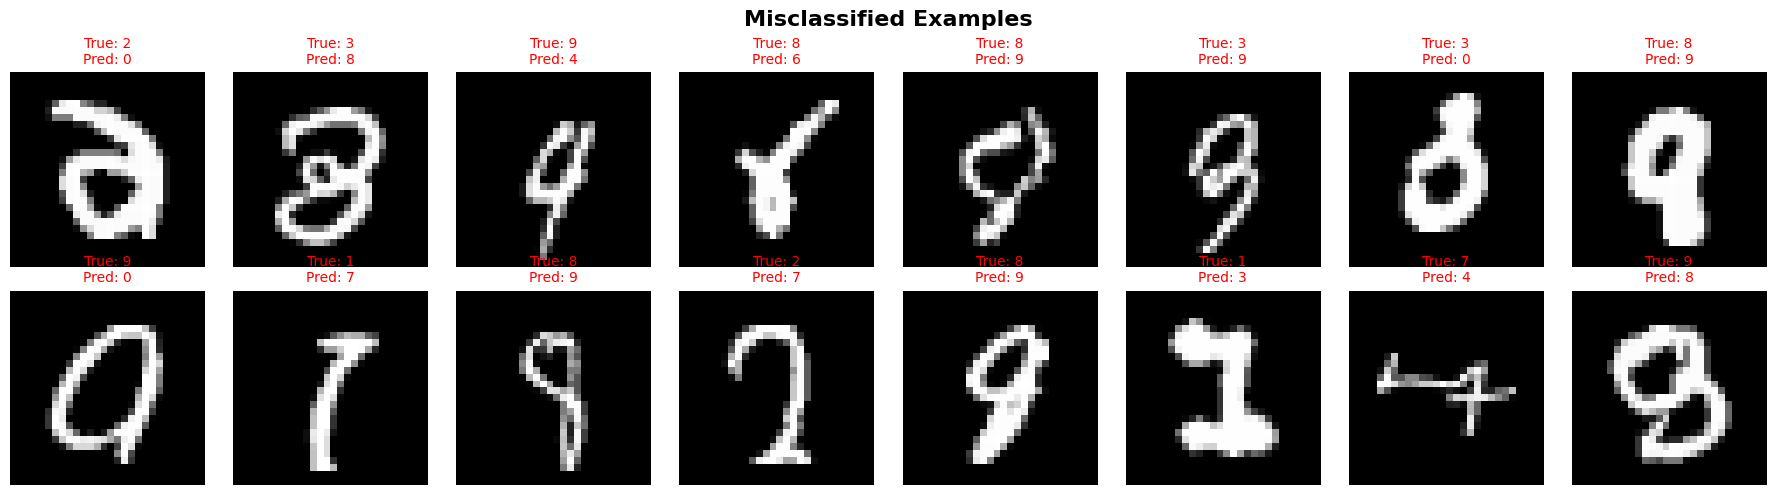

In [19]:
# Find misclassified examples
misclassified_indices = np.where(all_preds != all_labels)[0]
print(f"Total misclassified samples: {len(misclassified_indices)} out of {len(all_labels)}")
print(f"Misclassification rate: {100 * len(misclassified_indices) / len(all_labels):.2f}%")

# Show some misclassified examples
if len(misclassified_indices) > 0:
    num_show = min(16, len(misclassified_indices))
    sample_indices = np.random.choice(misclassified_indices, num_show, replace=False)
    
    fig, axes = plt.subplots(2, 8, figsize=(18, 5))
    axes = axes.flatten()
    
    for i, idx in enumerate(sample_indices):
        img = X_val[idx].reshape(28, 28)
        true_label = all_labels[idx]
        pred_label = all_preds[idx]
        
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}', color='red', fontsize=10)
        axes[i].axis('off')
    
    plt.suptitle('Misclassified Examples', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['model_save_path'], 'misclassified_examples.png'), dpi=150, bbox_inches='tight')
    plt.show()

## 18. Summary

In [20]:
print("="*70)
print("TRAINING SUMMARY")
print("="*70)
print(f"\nModel Architecture: CNN with {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Training Samples: {len(X_train):,}")
print(f"Validation Samples: {len(X_val):,}")
print(f"Epochs Trained: {CONFIG['epochs']}")
print(f"Batch Size: {CONFIG['batch_size']}")
print(f"\nBest Validation Accuracy: {best_val_acc:.2f}% (Epoch {best_epoch})")
print(f"Final Train Accuracy: {history['train_acc'][-1]:.2f}%")
print(f"Final Validation Accuracy: {history['val_acc'][-1]:.2f}%")
print(f"\nMisclassified Samples: {len(misclassified_indices)}/{len(all_labels)}")
print(f"Error Rate: {100 * len(misclassified_indices) / len(all_labels):.2f}%")
print(f"\nModels saved in: {CONFIG['model_save_path']}")
print(f"  - Best model: {CONFIG['best_model_name']}")
print(f"  - Final model: {CONFIG['final_model_name']}")
print("="*70)

TRAINING SUMMARY

Model Architecture: CNN with 437,738 parameters
Training Samples: 35,700
Validation Samples: 6,300
Epochs Trained: 30
Batch Size: 128

Best Validation Accuracy: 99.49% (Epoch 29)
Final Train Accuracy: 99.91%
Final Validation Accuracy: 99.44%

Misclassified Samples: 32/6300
Error Rate: 0.51%

Models saved in: models/
  - Best model: best_mnist_model.pth
  - Final model: final_mnist_model.pth
